# 16 - Training for Different Metrics

- Note, when we train for different metrics, the objective of the individual regression and the Cross-Validation stays the same! We just choose the model over the test set with the best metric! Its surprising we don't do cross validation with this too.

In [1]:
from setup import * #gets the real data

/media/ryan/5e52f95b-dbda-4605-bec6-10d513d58772/GitHubProjExt/effective-xgboost-notes/setup.py:32: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,42,44,54,56,64,81,83,85,87,105,107,109,121,123,125,148,150,157,172,174,192,194,210,218,219,221,223,246,247,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,302,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag = pd.read_csv(z.open(member_name))
/media/ryan/5e52f95b-dbda-4605-bec6-10d513d58772/GitHubProjExt/effective-xgboost-notes/setup.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
/media/ryan/5e52f95b-dbda-4605-bec6-10d513d58772/GitHubProjEx

In [26]:
import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, dummy, preprocessing, ensemble, metrics
import xgboost as xgb
import dtreeviz
from yellowbrick import model_selection as ms
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK, pyll
from typing import Any, Dict, Union, Sequence
#also, must install graphviz for plotting to work with xgb

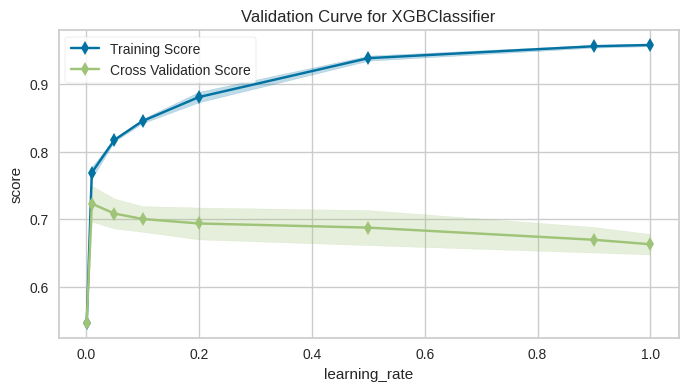

ValidationCurve(ax=<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,...
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                param_name='learning_rate',
                param_range=array([0.001, 0.01 , 0.05 , 0.1  , 0.2  , 0.5  , 0.9  , 1.   ]),
                scoring='accuracy')

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlabel("Accuracy")
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train, \
        scoring='accuracy', param_name='learning_rate',
        param_range=[0.001, .01, .05, .1, .2, .5, .9, 1], ax=ax)


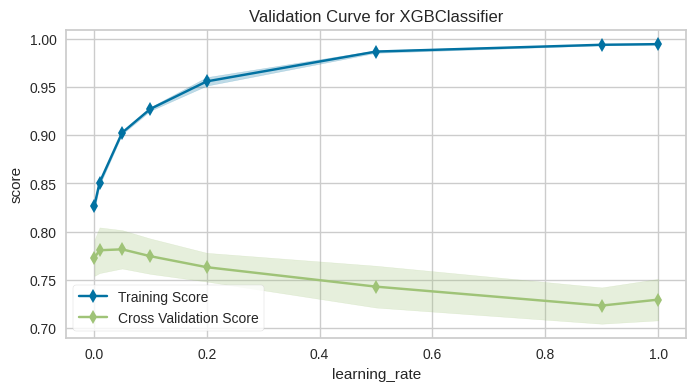

Text(0.5, 24.0, 'roc_auc')

In [6]:
fix, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train, \
        scoring='roc_auc', param_name='learning_rate', 
        param_range=[.001, .01, .05, .1, .2, .5, .9, 1], ax=ax)
ax.set(xlabel="roc_auc")

- The claim is that the CV score-maximizing learning rate for accuracy is around .01 while the CV score-maximizing learning rate for roc_auc is .05. So, want a higher learning rate for roc_auc maximization it seems.

## Step-wise Recall Learning

In [28]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]],\
    X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame,\
    y_test: pd.Series, early_stopping_rounds: int=50, metric:callable=metrics.accuracy_score) -> Dict[str, Any]:
    """
    Function for tuning hyperparameters. This is the wrong way to do it! Just a grid search/stepwise. 
    A better way is done in chapter 13. The better way takes a fraction of the time for the same parameters!
    """
    int_vals = ['max_depth','reg_alpha']
    space={k: (int(val) if k in int_vals else val) for k, val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    pred = model.predict(X_test)
    score = metric(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model':model}

In [29]:
params = {'random_state': 42}
rounds = [ {'max_depth':hp.quniform('max_depth',1,9,1), #tree
            'min_child_weight': hp.loguniform('min_child_weight',-2, 3) },
            {'subsample': hp.uniform('subsample', 0.5, 1), #stochastic
             'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
            {'gamma': hp.loguniform('gamma', -10, 10)}, #regularization
            {'learning_rate': hp.loguniform('learning_rate',-7, 0)} # boosting                 }

] #list of dictionaries

# optimize for tree, then subsample, then regularization, then learning_rate
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, y_train, X_test, y_test, metric=metrics.roc_auc_score),
                space=params,
                algo=tpe.suggest,
                max_evals=40,
                trials=trials
            )
    params = {**params, **best}


100%|██████████| 40/40 [00:18<00:00,  2.16trial/s, best loss: -0.7674379660549466]


In [30]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)
metrics.roc_auc_score(y_test, xgb_def.predict(X_test))

0.7495887388319198

In [31]:
params

{'random_state': 42,
 'max_depth': 4.0,
 'min_child_weight': 0.4107172848474063,
 'subsample': 0.9447467464944074,
 'colsample_bytree': 0.9599973427670607,
 'gamma': 0.15984164702730866,
 'learning_rate': 0.30058648120426196}

In [34]:
params['max_depth'] = params['max_depth'].astype(int)

In [35]:
xgb_tuned = xgb.XGBClassifier(**params, early_stopping_rounds=50, n_estimators=500)
xgb_tuned.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

[0]	validation_0-logloss:0.62710	validation_1-logloss:0.62480


[74]	validation_0-logloss:0.39832	validation_1-logloss:0.50527


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9599973427670607, device=None,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.15984164702730866,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.30058648120426196,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=0.4107172848474063, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [37]:
metrics.roc_auc_score(y_test, xgb_tuned.predict(X_test)) #much higher score for tuned over default

0.7674379660549466

## Conclusion

